In [ ]:
# Install correct PyTorch + CUDA version for Colab
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric packages that match this CUDA version
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-geometric itself
!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cu118 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.1.0+cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Coauthor
from torch_geometric.nn import SAGEConv
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset = Coauthor(root="/tmp/CS", name="CS")
data = dataset[0]

print(data)
print("Classes:", dataset.num_classes)
print("Features per node:", dataset.num_node_features)


Processing...
Done!


Data(x=[18333, 6805], edge_index=[2, 163788], y=[18333])
Classes: 15
Features per node: 6805


In [ ]:
def create_masks(data, train_ratio=0.1, val_ratio=0.1, seed=42):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_ratio)
    num_val = int(num_nodes * val_ratio)
    num_test = num_nodes - num_train - num_val

    indices = np.random.RandomState(seed).permutation(num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train+num_val]] = True
    test_mask[indices[num_train+num_val:]] = True

    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = create_masks(data, train_ratio=0.1, val_ratio=0.1)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

Training nodes: 1833
Validation nodes: 1833
Test nodes: 14667


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphSAGE().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
val_accs = []

best_val_acc = 0
patience = 20
counter = 0
best_model_state = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum() / data.val_mask.sum()
        val_accs.append(val_acc.item())

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Use the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Early stopping at epoch 68


In [ ]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
print("Test Accuracy:", float(test_acc))

Test Accuracy: 0.9280698299407959


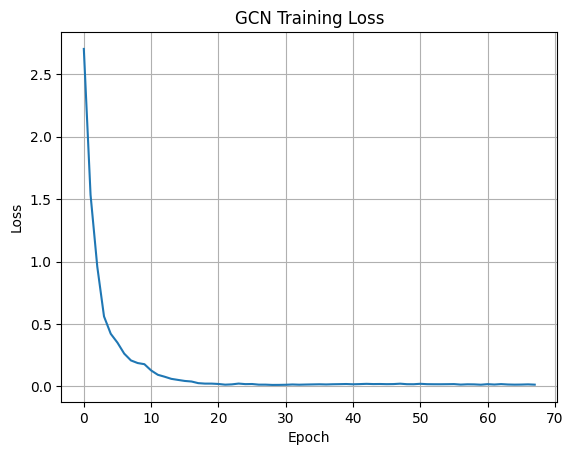

In [ ]:
plt.plot(train_losses)
plt.title("GCN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


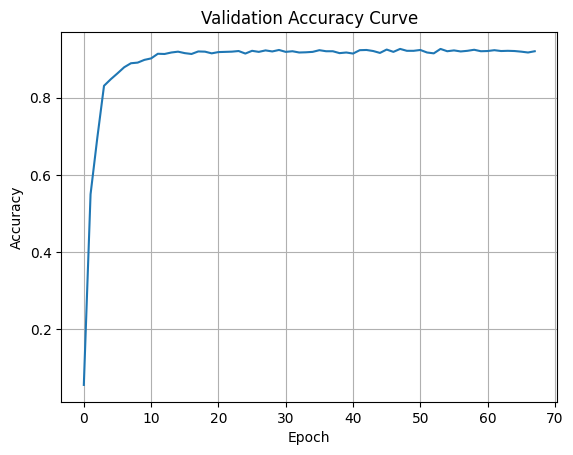

In [ ]:
plt.plot(val_accs)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


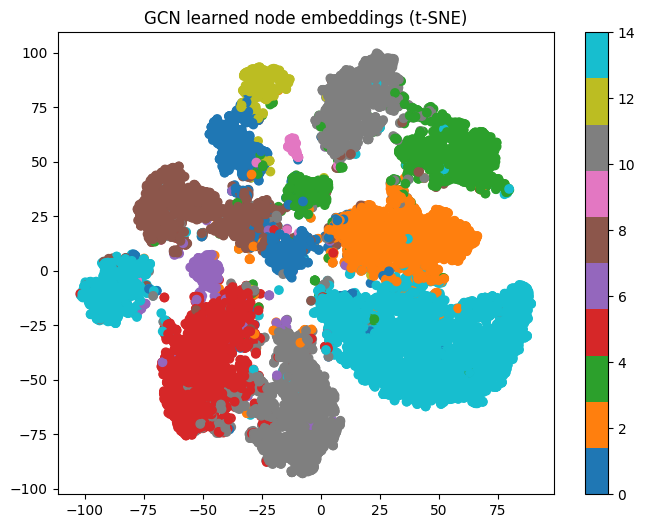

In [ ]:
from sklearn.manifold import TSNE

model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate='auto')
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=data.y.cpu(), cmap="tab10")
plt.title("GCN learned node embeddings (t-SNE)")
plt.colorbar()
plt.show()
